<h1 align="center">🏡 Apartment price prediction project 🏡</h1>

 <h4 align="center">
 <em>An application that predict the selling price of an apartment in Stockholm </em>
 <h4/>

### TODOS

- Impute values where #rooms is missing
- Add data exploration
- Add rewriting to enable links without https

### Imports

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

import requests
import pickle
import json
from datetime import date
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm as tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

### Scraping data from the web

In [4]:
# Function to calculate number of pages that can be scraped
url = 'https://www.booli.se/slutpriser/stockholm/1?page=1'

def get_nr_of_pages(url):
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.text, 'html.parser')
    select = soup.find('div', class_="EuKIv _36W0F")
    nr_of_objects = select.find('span').text.split(' ')[3]
    nr_of_pages = int(nr_of_objects) // 35 + 1
    print('nr of pages: ', nr_of_pages, '\nnr of objects: ', nr_of_objects)

get_nr_of_pages(url)

nr of pages:  5991 
nr of objects:  209681


In [5]:
# Retrieving the hrefs of the links in the page
nr_of_objects = 10000
hrefs = []

for i in range(1,nr_of_objects//35+2):
    url = 'https://www.booli.se/slutpriser/stockholm/1?page=' + str(i)
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.text, 'html.parser')
    select = soup.find('div', class_="_2m6km uC2y2 _3oDFL")
    links = select.find_all('a')
    links_in_this_page = [link.get('href') for link in links]
    hrefs.extend(links_in_this_page)
    hrefs = hrefs[0:nr_of_objects]

print('Collected', len(hrefs), 'links from', i, 'pages')

Collected 10000 links from 286 pages


In [38]:
# Function to scrape all the apartment information from the links in the hrefs list.

def get_apartment_info(url_suffix):
    url = 'https://www.booli.se' + url_suffix
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.text, 'html.parser')
    select = soup.find('div', class_="_2epd7 _12LuH")
    infobox_1 = soup.find('div', class_="_36W0F mz1O4")
    infobox_2 = soup.find('div', class_="_2IyrD _36W0F _16dH_")

    # extracting name, price, size and area from left infobox.
    name = infobox_2.find('h1').text
    price = infobox_2.find('h2').text
    size_and_area = infobox_2.findAll('h4')
    size = size_and_area[0].text
    area = size_and_area[1].text

    # extracting address from right infobox.
    upper_right_div = infobox_1.find('div', class_="_2epd7 _12LuH")

    try:
        date_sold = upper_right_div.findAll('div', class_="_18w8g")[3].text
    except:
        date_sold = 'N/A'

    try:
        monthly_fee_div = infobox_1.select('div:contains("Avgift")')[0]
        monthly_fee = monthly_fee_div.find('div', class_="_18w8g").text
    except:
        monthly_fee = 'N/A'

    return [name, price, size, area, url, monthly_fee, date_sold]

In [58]:
# Creating a dataframe with the scraped data, ignoring rows without relevant data

df = pd.DataFrame(columns=['name', 'price', 'size', 'area','url', 'monthly_fee', 'date_sold'])

for i in tqdm(range(nr_of_objects)):
    try:
        df.loc[i] = get_apartment_info(hrefs[i])
    except:
        print('Error with', hrefs[i], 'at', i)

  0%|          | 0/10000 [00:00<?, ?it/s]

Error with /annons/4719043 at 242
Error with /bostad/665243 at 250
Error with /annons/3123851 at 330
Error with /annons/4699652 at 376
Error with /bostad/2219982 at 601
Error with /bostad/3880316 at 848
Error with /bostad/133607 at 856
Error with /annons/3825608 at 919
Error with /annons/4094053 at 921
Error with /annons/1283967 at 1137
Error with /bostad/565121 at 1138
Error with /annons/1360677 at 1139
Error with /annons/1370114 at 1140
Error with /annons/1388368 at 1141
Error with /annons/1320082 at 1142
Error with /annons/1405455 at 1143
Error with /annons/1606984 at 1145
Error with /annons/1645173 at 1146
Error with /annons/1645192 at 1147
Error with /annons/1632401 at 1148
Error with /annons/1706581 at 1149
Error with /annons/1709323 at 1150
Error with /bostad/1917224 at 1151
Error with /bostad/1982320 at 1152
Error with /bostad/1843977 at 1153
Error with /bostad/1982324 at 1155
Error with /bostad/1477571 at 1156
Error with /bostad/2096967 at 1157
Error with /annons/1843716 at 11

In [59]:
# saving the dataframe to a csv file
# df.to_csv('housing_info.csv', index=False)

In [124]:
# reading the csv file
df = pd.read_csv('housing_info.csv')
print('Length of dataframe:', len(df))
df_copy = df.tail(100).copy()

Length of dataframe: 7983


### Clean the data

In [126]:
def clean_data(row):
    
    # convert price to int and delete ' kr'
    try:
        row['price'] = int(row['price'].replace(' kr', '').replace(' ', ''))
    except:
        print('Error with price', row['price'])
        row['price'] = 0

    # split up size into size and #rooms
    size_and_rooms = row['size'].replace('½', '.5').split(',')
    if len(size_and_rooms) > 1:
        row['size'] = float(size_and_rooms[0].split(' ')[0])
        row['rooms'] = float(size_and_rooms[1].split('rum')[0])
    else:
        row['size'] = float(size_and_rooms[0].split(' ')[0])
        row['rooms'] = 'N/A'

    # split up area into area and house type
    area_and_house_type = row['area'].split(',')
    row['area'] = area_and_house_type[1]
    row['type'] = area_and_house_type[0]

    # addin price per m2 to the dataframe
    row['price_per_m2'] = row['price'] / row['size']

    # convert monthly fee to int and delete ' kr'
    if str(row['monthly_fee'])=='nan':
        row['monthly_fee'] = 'N/A'
    elif str(row['monthly_fee']).find('m²')==-1:
        row['monthly_fee'] = int(str(row['monthly_fee']).split('kr')[0].replace(' ', ''))
    else:
        row['monthly_fee'] = 'N/A'

    # convert date_sold to int
    try:
        row['date_sold'] = int(row['date_sold'].replace(' ', '').replace('-', ''))
    except:
        row['date_sold'] = 0

    return row

df = df.apply(clean_data, axis=1)
df['price_per_m2'] = df['price_per_m2'].round(2)

Error with price Pris saknas
Error with price Pris saknas
Error with price Pris saknas
Error with price Pris saknas
Error with price Pris saknas
Error with price Pris saknas


### Data exploration and cleaning

In [127]:
# df['area'].unique()
# df['type'].unique()

# count nr of rows with monthly fee = 'N/A'
# df['monthly_fee'].value_counts()

# count nr of rows with date_sold = 'N/A'
# df['date_sold'].value_counts()

# count nr of rows with price = 0
# len(df[df['price']==0])

dropping faulty rows

In [128]:
df[df['area']==' Två']

# change are from ' Två' to 'Norrmalm', seems to be some typos at the source
df.loc[df['area']==' Två', 'area'] = ' Tegnérlunden'

In [156]:
# check if monthly fee contains any nan
df['monthly_fee'].isna().sum()

0

In [155]:
# dropping irrelevant rows from df
print('Rows before cleaning:', len(df))
df = df[df['area']!=' 1 rum']
df = df[df['type']!='32 m²']
df = df[df['price']!=0]

# drop nan rows from monthly fee
df.dropna(subset = ['monthly_fee'], inplace=True)

# drop nan values in rooms (for now), change this later
df = df[df['rooms']!='N/A']
print('Rows after cleaning:', len(df))

Rows before cleaning: 7518
Rows after cleaning: 6912


In [157]:
# count average price per m2 for each area
print('Nr of unique areas:', len(df['area'].unique()))
df_average_price_in_area = df.groupby('area')['price_per_m2'].mean().reset_index().round(0)
df_average_price_in_area.rename(columns={'price_per_m2': 'price_per_m2_avg'}, inplace=True)
df_average_price_in_area.sort_values(by='price_per_m2_avg', ascending=False, inplace=True)
df_average_price_in_area.head(10)

Nr of unique areas: 312


,area,price_per_m2_avg
250,Tegnérlunden,174390.0
257,Vasaparken,150685.0
266,Vasastan Östermalm,139781.0
180,Odenplan Vasaparken Vasastan,138876.0
307,Östermalm / Nedre Gärdet,138043.0
245,Södermalm-Högalid,136751.0
76,Hagastaden Vasastan,135873.0
305,Östermalm,130278.0
15,Birkastan Vasastan,129565.0
242,Södermalm Mosebacke,128409.0


In [158]:
# convert df_average_price_in_area to a dictionary
average_price_in_area = df_average_price_in_area.set_index('area').T.to_dict('list')

#export to json
with open('average_price_in_area.json', 'w') as f:
    json.dump(average_price_in_area, f)

# apply lambda function to df to get average price per m2 for each area
df['area_price_per_m2'] = df.apply(lambda row: average_price_in_area[row['area']][0], axis=1)

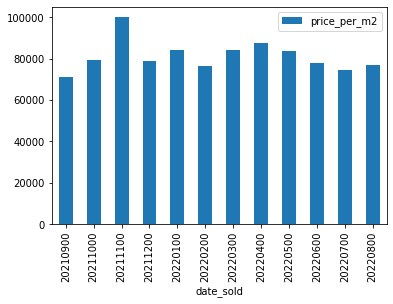

In [159]:
df['date_sold'].value_counts()

# print average price per m2 and group by date_sold
df_average_price_in_area = df.groupby('date_sold')['price_per_m2'].mean().reset_index()
df_average_price_in_area['date_sold'] = df_average_price_in_area['date_sold'].round(-2)
df_average_price_in_area = df_average_price_in_area.groupby('date_sold')['price_per_m2'].mean().reset_index()

# round date_sold to nearest 100

# drop all rows with date_sold lower than 20210825
df_average_price_in_area = df_average_price_in_area[df_average_price_in_area['date_sold']>=20210825]

# plot average price per m2 for each date_sold in a bar chart 
df_average_price_in_area.plot(x='date_sold', y='price_per_m2', kind='bar')
# show fewer values in x axis

plt.show()

There seems to be some fluctutations of prices depending on month. However, I will not take this into account for now

Since we don't want to use categorical data, we can replace the area with the average selling price / m2.

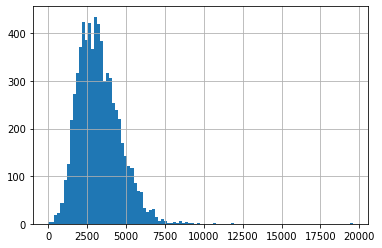

In [160]:
# plot histogram of monthly fee
df['monthly_fee'].hist(bins=100)
plt.show()

In [161]:
# exporting the data to a csv file
# df.to_csv('df_cleaned.csv', index=False)

## Training the model

In [196]:
# reading the csv file
df = pd.read_csv('df_cleaned.csv')

In [197]:
df_x = df[['size', 'rooms', 'area_price_per_m2', 'monthly_fee']]
df_y = df['price']

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

In [198]:
#XGB Regressor 
rf_regressor = RandomForestRegressor(n_estimators=20) #max_depth=15
rf_regressor.fit(x_train, y_train)
y_pred = rf_regressor.predict(x_test)

In [199]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 562724.91798878


In [200]:
from sklearn.model_selection import cross_val_score

# use cross validation to find the best number of estimators
scores = cross_val_score(rf_regressor, x_train, y_train, cv=5)
print('Cross validation scores:', scores)
print('Mean cross validation score:', scores.mean())


Cross validation scores: [0.91179262 0.88113825 0.88296714 0.89616041 0.90301095]
Mean cross validation score: 0.8950138741000015


In [201]:
# Trying out the regressor on two cases
print("Real price:", int(y_test.head(1)))
print("Predicted price: ",rf_regressor.predict(x_test.head(1))[0])
print("Real price:", int(y_test.tail(1)))
print("Predicted price: ",rf_regressor.predict(x_test.tail(1))[0])

Real price: 3500000
Predicted price:  3632250.0
Real price: 9400000
Predicted price:  9256250.0


In [210]:
# Exporting model to pickle file
pickle.dump(rf_regressor, open('../models/rf_regressor.pkl', 'wb'))